### Install Requirements

In [40]:
!pip install torch torchvision albumentations segmentation-models-pytorch scikit-learn matplotlib

### Download Data

In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/sofiautoft/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1


### Load & Resize Data

In [42]:
import cv2 as cv
import numpy as np
import os

def load_images_from_folder(dataset_path, img_size=(256, 256)):
    images, masks = [], []
    categories = ['benign', 'normal', 'malignant']

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        image_files = sorted([f for f in os.listdir(category_path) if "mask" not in f.lower()])
        mask_files = sorted([f for f in os.listdir(category_path) if "mask" in f.lower()])

        for img_file, mask_file in zip(image_files, mask_files):
            print(f"Loading: {img_file} and {mask_file}")
            img_path, mask_path = os.path.join(category_path, img_file), os.path.join(category_path, mask_file)
            img, mask = cv.imread(img_path), cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

            if img is not None and mask is not None:
                images.append(cv.resize(img, img_size) / 255.0)
                masks.append(cv.resize(mask, img_size) / 255.0)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

data_path = os.path.expanduser("/Users/sofiautoft/.cache/kagglehub/datasets/aryashah2k/breast-ultrasound-images-dataset/versions/1/Dataset_BUSI_with_GT")
images, masks = load_images_from_folder(data_path)


Loading: benign (1).png and benign (1)_mask.png
Loading: benign (10).png and benign (10)_mask.png
Loading: benign (100).png and benign (100)_mask.png
Loading: benign (101).png and benign (100)_mask_1.png
Loading: benign (102).png and benign (101)_mask.png
Loading: benign (103).png and benign (102)_mask.png
Loading: benign (104).png and benign (103)_mask.png
Loading: benign (105).png and benign (104)_mask.png
Loading: benign (106).png and benign (105)_mask.png
Loading: benign (107).png and benign (106)_mask.png
Loading: benign (108).png and benign (107)_mask.png
Loading: benign (109).png and benign (108)_mask.png
Loading: benign (11).png and benign (109)_mask.png
Loading: benign (110).png and benign (11)_mask.png
Loading: benign (111).png and benign (110)_mask.png
Loading: benign (112).png and benign (111)_mask.png
Loading: benign (113).png and benign (112)_mask.png
Loading: benign (114).png and benign (113)_mask.png
Loading: benign (115).png and benign (114)_mask.png
Loading: benign (1

In [43]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

# Create the DeepLabV3+ model
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",      
    encoder_weights="imagenet",     # use ImageNet pre-trained weights
    in_channels=3,                  # ultrasound images: 3 if RGB
    classes=1                       # binary segmentation (tumor vs. background)
)

In [44]:
import torch.nn.functional as F

def pad_to_multiple_of_16(image):
    # Get the current height and width of the image
    height, width = image.shape[:2]

    # Compute the padding needed
    pad_h = (16 - height % 16) % 16  # Ensure the pad is a multiple of 16
    pad_w = (16 - width % 16) % 16   # Ensure the pad is a multiple of 16

    # Apply padding to the image
    padded_image = F.pad(image, (0, pad_w, 0, pad_h), mode='constant', value=0)
    return padded_image

In [45]:
from torch.utils.data import Dataset
import cv2
import numpy as np

class UltrasoundDataset(Dataset):
    def __init__(self, image_arrays, mask_arrays, transforms=None):
        self.image_arrays = image_arrays
        self.mask_arrays = mask_arrays
        self.transforms = transforms

    def __len__(self):
        return len(self.image_arrays)
    
    def __getitem__(self, idx):
        image = self.image_arrays[idx]   # already numpy array
        mask = self.mask_arrays[idx]     # already numpy array
        mylist = [image, mask]
    
        for i in range(2):
            item = mylist[i]
            h, w = item.shape[:2]

            # Compute the padding needed
            new_h = (h + 15) // 16 * 16 
            new_w = (w + 15) // 16 * 16 

            # Apply padding to the image or mask
            mylist[i] = np.pad(item, ((0, new_h - h), (0, new_w - w), (0, 0)), mode='constant', constant_values=0)

        # Convert to torch tensors
        image = torch.tensor(mylist[0]).permute(2, 0, 1).float()
        mask = torch.tensor(mylist[1]).permute(2, 0, 1).float()

        return image, mask

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
positive_weight = torch.tensor([1.0]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=positive_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [47]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Split the dataset into training and validation sets
indices = list(range(len(images)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_images = [images[i] for i in train_idx]
train_masks = [masks[i] for i in train_idx]
val_images = [images[i] for i in val_idx]
val_masks = [masks[i] for i in val_idx]

train_dataset = UltrasoundDataset(train_images, train_masks)
val_dataset = UltrasoundDataset(val_images, val_masks)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)

        loss = loss_fn(outputs, masks.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

KeyboardInterrupt: 

In [ ]:
def iou_score(preds, targets, threshold=0.3):
    preds = (preds > threshold).float()
    targets = targets.float()

    intersection = (preds * targets).sum(dim=(1,2)) 
    union = preds.sum(dim=(1,2)) + targets.sum(dim=(1,2)) - intersection

    iou = (intersection + 1e-6) / (union + 1e-6)  
    return iou.mean()

def dice_score(preds, targets, threshold=0.3):
    preds = (preds > threshold).float()
    targets = targets.float()
    
    intersection = (preds * targets).sum(dim=(1,2))  
    dice = (2. * intersection + 1e-6) / (preds.sum(dim=(1,2)) + targets.sum(dim=(1,2)) + 1e-6)
    return dice.mean()

In [ ]:
model.eval()
total_iou = 0.0
total_dice = 0.0
num_batches = 0

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)

        iou = iou_score(outputs, masks)
        dice = dice_score(outputs, masks)

        total_iou += iou.item()
        total_dice += dice.item()
        num_batches += 1

        val_loss = loss_fn(outputs, masks.float())
        val_losses.append(val_loss.item())
        

average_iou = total_iou / num_batches
average_dice = total_dice / num_batches

print(f"Average IoU: {average_iou:.4f}, Average Dice: {average_dice:.4f}")

Average IoU: 0.6085, Average Dice: 0.6290


In [ ]:
import matplotlib.pyplot as plt

def plot_segmentation_comparison(images, true_masks, pred_masks, num_images=5):
    """
    Visualize model predictions alongside ground truth masks for a few examples.
    
    Args:
        images (tensor): The input images.
        true_masks (tensor): The ground truth masks.
        pred_masks (tensor): The predicted masks.
        num_images (int): Number of images to display.
    """
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
        plt.title(f"Image {i + 1}")
        plt.axis('off')
        
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[i].cpu().numpy().transpose(1, 2, 0), cmap='gray')
        plt.title(f"True Mask {i + 1}")
        plt.axis('off')
        
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(pred_masks[i].cpu().numpy(), cmap='gray')  # No transpose needed
        plt.title(f"Predicted Mask {i + 1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

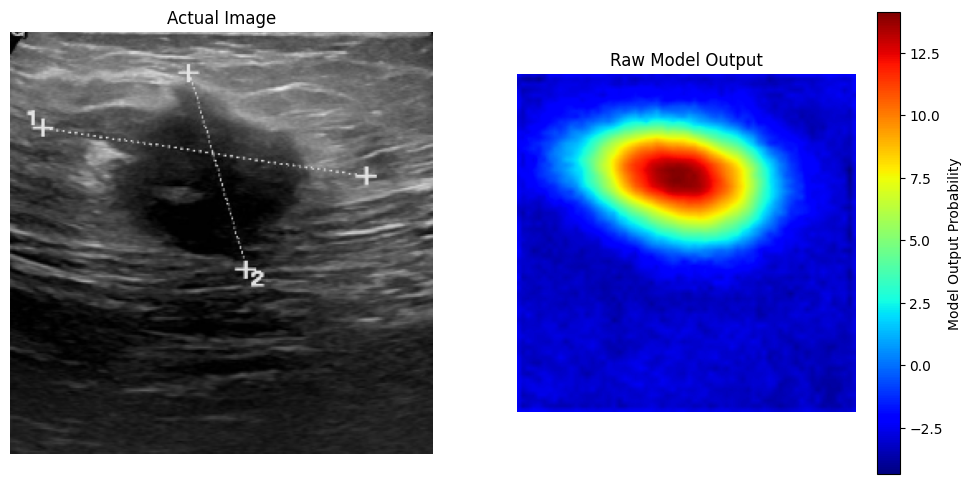

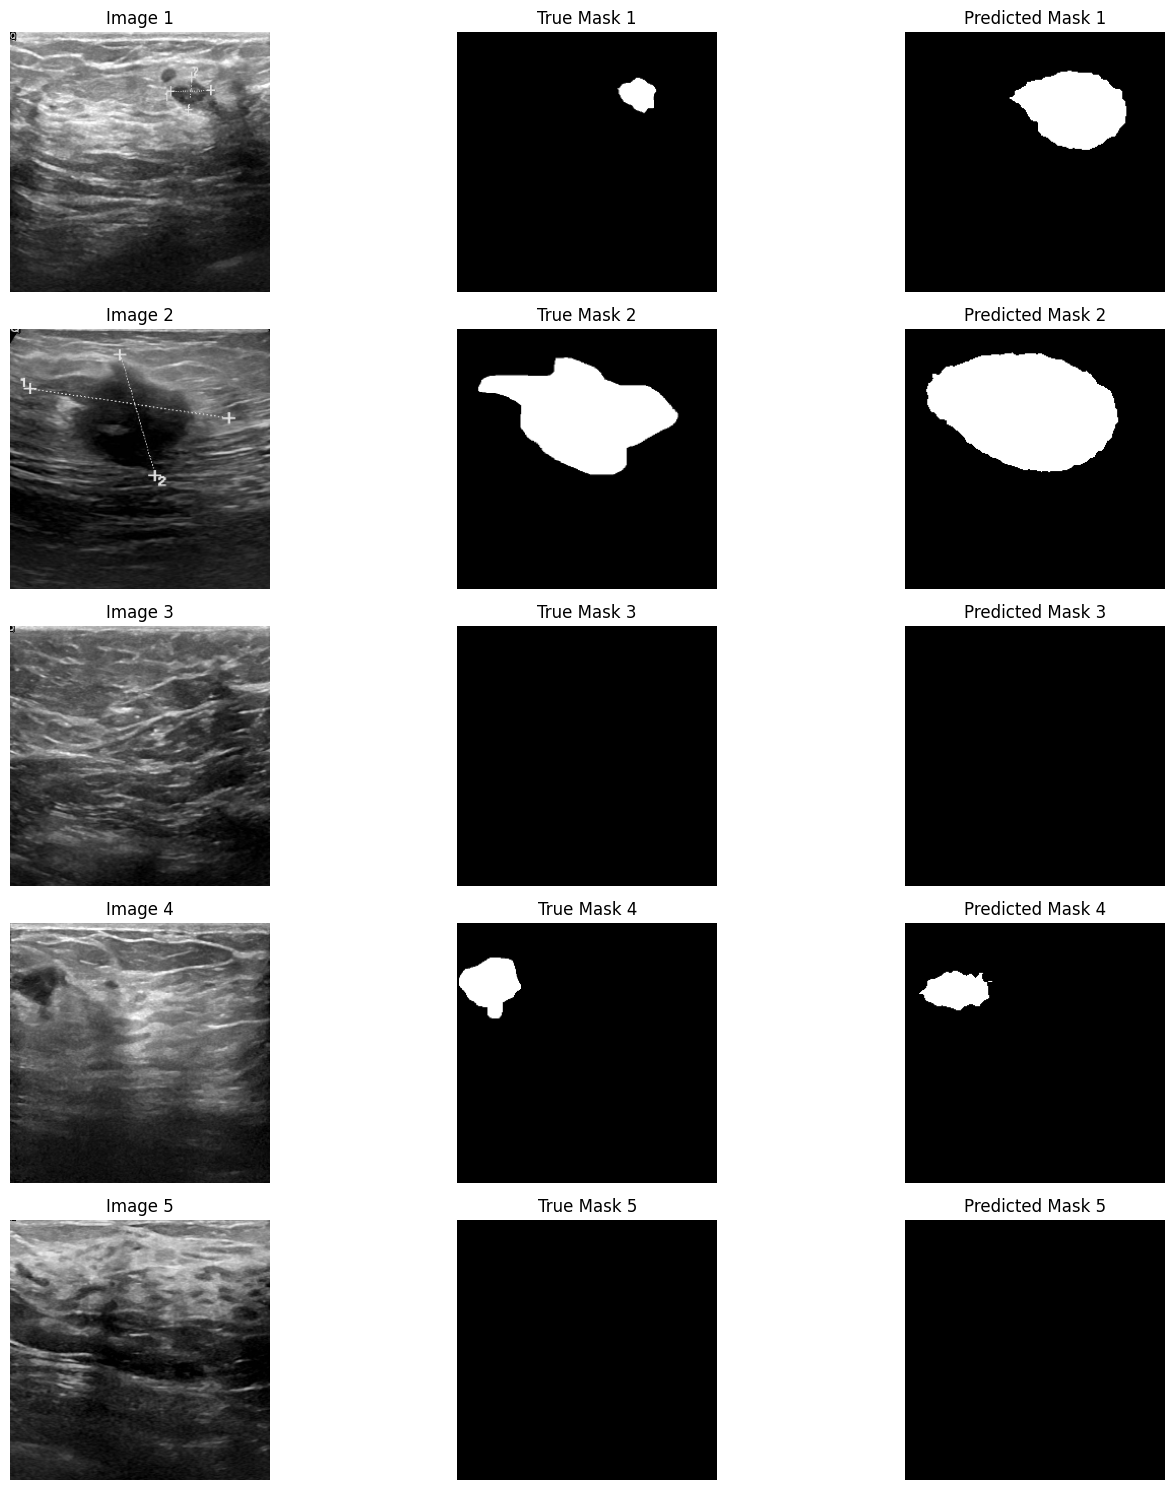

In [ ]:
with torch.no_grad():
        images, masks = next(iter(val_loader))
        images = images.to(device)
        masks = masks.to(device)

        # Get model outputs
        outputs = model(images)

        # Visualize raw output for one image
        raw_output = outputs[1].cpu().detach().numpy()  # Get raw output for one image
        plt.figure(figsize=(12, 6))

        # Plot the actual image
        plt.subplot(1, 2, 1)
        plt.imshow(images[1].cpu().numpy().transpose(1, 2, 0))
        plt.title("Actual Image")
        plt.axis('off')

        # Plot the raw output
        plt.subplot(1, 2, 2)
        plt.imshow(raw_output[0], cmap='jet') 
        plt.title("Raw Model Output")
        plt.axis('off')
        plt.colorbar(label='Model Output Probability')
        plt.show()

        # Apply sigmoid and threshold to generate binary masks
        outputs = torch.sigmoid(outputs)
        pred_masks = (outputs > 0.3).float()

        # Ensure pred_masks has the same shape as masks
        pred_masks = pred_masks.squeeze(1)  
        # Plot segmentation comparison
        plot_segmentation_comparison(images, masks, pred_masks)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses):
    """
    Plot the training loss curve.
    
    Args:
        train_losses (list): List of training losses.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

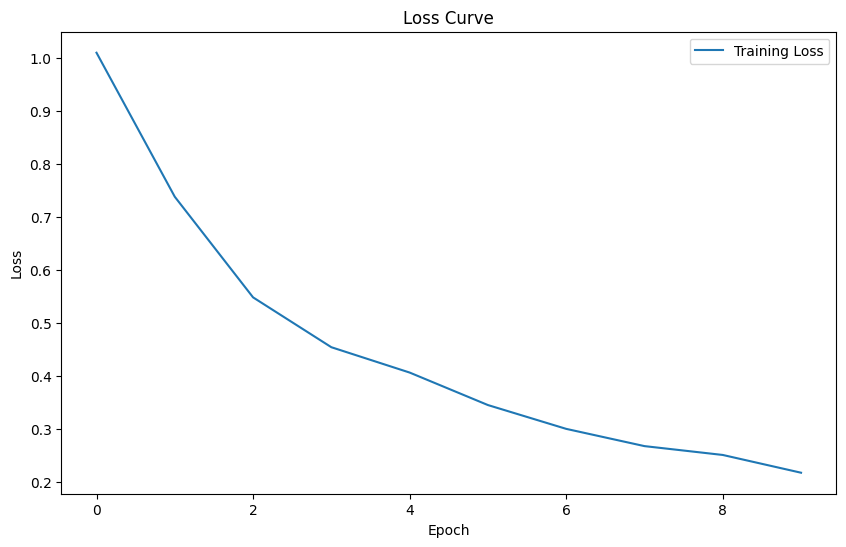

In [ ]:
plot_loss_curve(train_losses)